In [1]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import datetime
import cftime
import netCDF4
warnings.filterwarnings("ignore")
plt.style.use("default")
import os
from global_land_mask import globe
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
from matplotlib import cm
import global_land_mask
import logging
import matplotlib.dates as mdates
import xskillscore as xs
import CMIP6_xgrid_utils
from CMIP6_ridgeplot import CMIP6_ridgeplot
from CMIP6_IO import CMIP6_IO
from shapely.geometry import box, mapping
sns.set_theme(font_scale=1.5, style="whitegrid")
io = CMIP6_IO()

# Compare GHI from ERA5 and RTM for 1979-01-01 to 2023-12-16
Script that compares the ERA5 and RTM GHI irradiance for the Barents Sea region. We select the period 1979-01-01 to 2023-12-16 for the comparison and we used script `CMIP6_download_ERA5.ipynb` to download the ERA5 data from Copernicus. ERA5 data can be downloaded from Copernicus: https://climate.copernicus.eu/climate-reanalysis


RTM: The GHI data covers the full wavelength range 200-2700 nm.

ERA5: The global horizontal irradiation (GHI) is offered as shortwave radiation in Watt per square meter W/m². It is the sum of direct and diffuse radiation on the horizontal plane. These values are not instantaneous, but backwards averaged over the preceding hour. A value at 14:00 is the average irradiation between 13:00 and 14:00. Therefore, these values cannot be compared directly with instantaneous measurements.

In [2]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)

def get_LME_records_180():
    lme_file = "gs://actea-shared/Shapefiles/LME66_180/LME66_180.shp"
    return gpd.read_file(lme_file)

def clip_using_highres_world(ds, LME, var_name):
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    shdf = gpd.read_file(lme_file)
    shdf_4326 = shdf.to_crs(epsg=4326)
    shdf_sel = shdf_4326[shdf_4326["LME_NAME"] == LME]

    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    
    if "x" in ds.dims:
        ds.rio.set_spatial_dims(y_dim="y", x_dim="x", inplace=True)
    else:
        ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
    ds.rio.write_crs(4326,  inplace=True)
                
    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    if "x" in ds.dims:
        clipped = clipped.rename({"x": "lon", "y": "lat"}) 
        
    #clip the data
    data_clipped = clipped.rio.clip(world.geometry.apply(mapping), world.crs, drop = True)           
    data_clipped['mask'] = xr.where(np.isnan(data_clipped[var_name]), 1, np.nan)        
    clipped = clipped * data_clipped['mask']
                
    # Mask out indices where values are always zero across latitude
    clipped = clipped.fillna(0.0)
    always_zero = ~(clipped[var_name].any(dim='time') != 0)
    masked_da = clipped.where(~always_zero)
    
    return masked_da
            
def get_data_within_LME(ds,var_name,LME):

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()

    shdf_sel = shdf[ shdf['LME_NAME']==LME ]
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)

    
    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

   # data_clipped = tos.rio.clip(world.geometry.apply(mapping), world.crs, drop = True)           
   # data_clipped['mask'] = xr.where(np.isnan(data_clipped[var_name]), 1, np.nan)        
   # tos = tos * data_clipped['mask']
    
    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.


    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'})
    if isinstance(clipped, xr.DataArray):
        clipped = clipped.to_dataset()
    
      
    # Mask out indices where values are always zero across latitude
    clipped = clipped.fillna(0.0)
    always_zero = ~(clipped[var_name].any(dim='time') != 0)
    masked_da = clipped.where(~always_zero)
    return masked_da

In [3]:
def get_era5(era_datafile, start_time, end_time):
    era = netCDF4.Dataset(era_datafile)
    units = 'hours since 1900-01-01 00:00:00.0'
    time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')
    units_to_wm2 =1./3600.

    times=[]
    for t in time_gregorian:
        obj = datetime.datetime(year=t.year, month=t.month, day=t.month, hour=t.hour)
        times.append(obj)
    times = pd.to_datetime(times,dayfirst=False)

    era = xr.open_dataset(era_datafile,
                          mask_and_scale=True)*units_to_wm2

    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    return era.rename({"latitude":"lat", "longitude":"lon"}).sel(time=slice(start_time,end_time))

def get_mean_era5(era_datafile, start_time, end_time):
    era = netCDF4.Dataset(era_datafile)    
    units = 'hours since 1900-01-01 00:00:00.0'
    time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')
    units_to_wm2 =1.

    times=[]
    for t in time_gregorian:
        obj = datetime.datetime(year=t.year, month=t.month, day=t.month, hour=t.hour)
        times.append(obj)
    times = pd.to_datetime(times,dayfirst=False)

    era = xr.open_dataset(era_datafile,
                          mask_and_scale=True)*units_to_wm2

    era = era.sel(expver=1).drop("expver")
    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    return era.rename({"latitude":"lat", "longitude":"lon"}).sel(time=slice(start_time,end_time))

def convert_to_180(ds):
    ds = (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby("lon")
    return ds

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes["time"].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds

def get_area_averaged_ds(fname,scenario,model,start_time,end_time):

    if isinstance(fname, xr.Dataset):
        ds = fname
    else:
        ds = io.open_dataset_on_gs(fname)
  
    if isinstance(ds, xr.Dataset):
        ds=convert_to_180(ds)
  
        ds=ds.sel(time=slice(start_time, end_time)).mean({"lat","lon"})
        df = ds.to_dataframe().dropna()
        df = df.reset_index()
        df["scenario"]=scenario
        df["model"]=model

        return df

In [4]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

# Calculate stats on dataframe
def calculate_stats(df, var_name):
    # https://stackoverflow.com/questions/53519823/confidence-interval-in-python-dataframe
    stats = df[var_name].groupby(df.time.dt.month).agg(['mean', 'count', 'std', q25, q75,])
    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s, mi, ma = stats.loc[i]
        ci95_hi.append(m + s)
        ci95_lo.append(m - s)

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    return stats

[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ensemble/CMIP6_ensemble_stats_ssp245_ghi_weighted.nc
Correlation for Barents Sea ensemble  -0.230 (0.14200178) : rmse: 2.833
Correlation PAR:           mean_x    mean_y
mean_x  1.000000  0.997602
mean_y  0.997602  1.000000
Created figure Figures/CMIP6_lightpaper_sw+uv_compared_ERA_Barents Sea.png


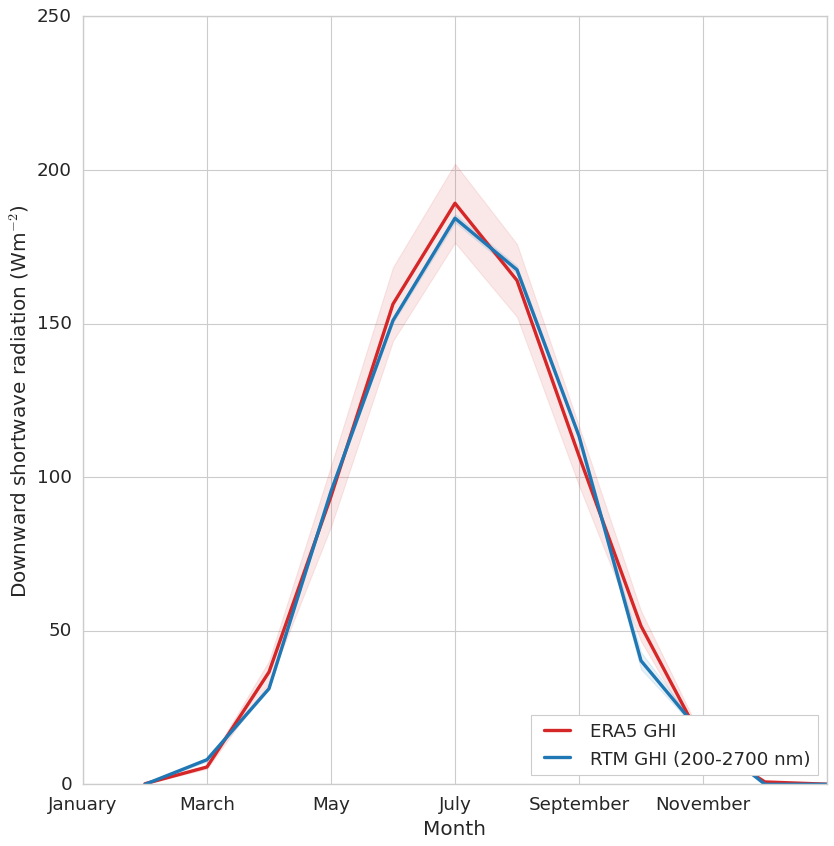

In [5]:
scenarios=["ssp245"]
member_range=1
ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                           range(member_range)
                           for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]

period="1979-01-01-2099-12-16"
start_time="1979-01-01"
end_time="2020-12-16"
min_lat=60
max_lat=85
min_lon=-180
max_lon=180

models=["CanESM5_r3i1p2f1","CanESM5_r7i1p2f1", 
        "MPI-ESM1-2-HR_r1i1p1f1","MPI-ESM1-2-HR_r2i1p1f1", 
        "UKESM1-0-LL_r1i1p1f2","MPI-ESM1-2-LR_r1i1p1f1",
        "MPI-ESM1-2-LR_r2i1p1f1","CanESM5_r10i1p2f1"]

models=["ensemble"] #"ensemble"] #""CanESM5_r10i1p2f1", "CanESM5_r7i1p2f1"]

era_var_name1="msnswrf"
ds_var_name1="ghi" 
root = f"light/ncfiles_nobias"

LMES=['Barents Sea'] #,'Northern Bering - Chukchi Seas']

era_datafile="/mnt/disks/actea-disk-1/light/era5/ERA5_global_mean_shortwave_uvb.nc"
era = get_mean_era5(era_datafile, start_time, end_time).compute()
era = era.reindex(lat=list(reversed(era.lat)))

era = era.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))
era_ds1=era 

for LME in LMES:

    era5_sw = get_data_within_LME(era_ds1, era_var_name1, LME).resample(time="MS").mean().sel(lat=slice(60,76), lon=slice(20,40))   
    sw_dfs=[]

    for scenario in scenarios:
        for model in models:
            if model == "ensemble":
                fname1 = f"{root}/{scenario}/ensemble/CMIP6_ensemble_stats_{scenario}_ghi_weighted.nc"
                ds_var_name1=f"{ds_var_name1}_mean"
                osa="osa_mean"
            else:
                fname1 = f"{root}/{scenario}/{ds_var_name1}_{model}_1979-01-01-2099-12-16_scenario_osa_{scenario}.nc"
                osa="osa"
                
         
            # CALCULATE NET RTM SHORTWAVE RADIATION
            ds_rtm = io.open_dataset_on_gs(fname1).sel(time=slice(start_time, end_time)).resample(time="MS").mean().sel(lat=slice(71,76), lon=slice(20,40))  
            
            era1 = era5_sw.mean({"lat","lon"})
            era_df1=era1.to_dataframe().reset_index()
            ds_rtm_absorbed=ds_rtm
            ds_rtm_absorbed = get_data_within_LME(ds_rtm_absorbed, ds_var_name1, LME)
            
            frequency="A"    
            ds_rtm_absorbed_corr = ds_rtm_absorbed.mean({"lat", "lon"}).sel(time=slice(start_time,end_time))
            ds_rtm_absorbed_corr= ds_rtm_absorbed_corr[ds_var_name1].resample(time=frequency).mean(skipna=True)
            era1_corr = era1.sel(time=slice(start_time,end_time))
            era1_corr=era1_corr[era_var_name1]
            
            r = xs.pearson_r(ds_rtm_absorbed_corr, 
                                era1_corr.resample(time=frequency).mean(skipna=True), 
                                dim='time')
            rmse = xs.rmse(ds_rtm_absorbed_corr, 
                                era1_corr.resample(time=frequency).mean(skipna=True), 
                                dim='time')
            p = xs.pearson_r_p_value(ds_rtm_absorbed_corr, 
                                era1_corr.resample(time=frequency).mean(skipna=True), 
                                dim='time')
            
            print(f"Correlation for {LME} {model}  {r:2.3f} ({p:2.8f}) : rmse: {rmse:3.3f}")
            
            df1 = get_area_averaged_ds(ds_rtm_absorbed,scenario,model,start_time,end_time)
           
            if df1 is not None and isinstance(df1, pd.DataFrame):
                sw_dfs.append(df1)
           
    sw_df=pd.concat(sw_dfs)
    
    # Shortwave radiation as function of month (mean + 0.95 CI)
    era_df_mean1 = calculate_stats(era_df1, era_var_name1)
    sw_mean = calculate_stats(sw_df, ds_var_name1)

    fig1=plt.figure(figsize=(12,12))
    axes1 = fig1.add_subplot(111)
    
    axes1.plot(era_df_mean1.index, era_df_mean1["mean"], linewidth=3, alpha=1.0, color="tab:red", label="ERA5 GHI")
    axes1.fill_between(era_df_mean1.index, era_df_mean1["ci95_lo"], era_df_mean1["ci95_hi"], alpha=0.1, color="tab:red")

    axes1.plot(sw_mean.index, sw_mean["mean"], linewidth=3, alpha=1.0, color="tab:blue", label=f"RTM GHI (200-2700 nm)")
    axes1.fill_between(sw_mean.index, sw_mean["ci95_lo"], sw_mean["ci95_hi"], alpha=0.1, color="tab:blue")
    axes1.legend(loc="lower right")

    my_xticks = ['January','March','May','July','September','November']
    axes1.set_xticklabels(my_xticks)


    axes1.set_ylabel("Downward shortwave radiation (Wm$^{-2}$)")
    axes1.set_xlabel("Month")

    merged = pd.merge_asof(era_df_mean1["mean"], sw_mean["mean"], left_index=True, right_index=True, direction='nearest')
   
    print("Correlation PAR: {}".format(merged.corr()))

    plotfile=f"Figures/CMIP6_lightpaper_sw+uv_compared_ERA_{LME}.png"
    print(f"Created figure {plotfile}")
    plt.savefig(plotfile, dpi=300, bbox_inches = 'tight')
    plt.show()
